In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import pickle

# Function to download and preprocess the stock data
def download_and_preprocess_data(tickers, start_date, end_date):
    dfs = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        dfs[ticker] = df
    combined_df = pd.DataFrame()
    for ticker, df in dfs.items():
        combined_df[ticker] = df['Close']
    return combined_df, dfs

# Function to train and save the model
def train_and_save_model(X_train, y_train, epochs=50, filename='model.pkl'):
    np.random.seed(42)  # Set random seed for reproducibility

    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        GRU(units=50, return_sequences=True),
        Dropout(0.2),
        GRU(units=50),
        Dropout(0.2),
        Dense(units=len(tickers))  # Change units to the number of tickers
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)


    # Save the trained model
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print("Model saved successfully.")

# Function to load the saved model
def load_model(filename='model.pkl'):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model

# Function to calculate evaluation metrics
def calculate_evaluation_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Define the stock data parameters
tickers = ['RELIANCE.NS', 'INFY.NS', 'LT.NS', 'ADANIENT.NS']
start_date = '2019-01-01'
end_date = datetime.now()

# Download and preprocess the data
combined_df, dfs = download_and_preprocess_data(tickers, start_date, end_date)
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(combined_df)
time_step = 60  # Number of time steps
X = []
y = []
for i in range(len(scaled_data) - time_step):
    X.append(scaled_data[i:i + time_step])
    y.append(scaled_data[i + time_step])
X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train and save the model
train_and_save_model(X_train, y_train, epochs=50, filename='model.pkl')

# Load the saved model
loaded_model = load_model(filename='model.pkl')

# Evaluate the model on the test set
predictions = loaded_model.predict(X_test)
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test)

# Calculate evaluation metrics for each ticker separately
evaluation_results = {}
for i, ticker in enumerate(tickers):
    mse, mae, r2 = calculate_evaluation_metrics(y_test_original_scale[:, i], predictions_original_scale[:, i])
    evaluation_results[ticker] = {'MSE': mse, 'MAE': mae, 'R2 Score': r2}

# Print evaluation metrics for each ticker separately
for ticker, results in evaluation_results.items():
    print(f"Evaluation metrics for {ticker}:")
    print(f"MSE: {results['MSE']}")
    print(f"MAE: {results['MAE']}")
    print(f"R2 Score: {results['R2 Score']}")
    print()



/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
31/31 [==============================] - 18s 120ms/step - loss: 0.0425
Epoch 2/50
31/31 [==============================] - 3s 85ms/step - loss: 0.0120
Epoch 3/50
31/31 [==============================] - 3s 107ms/step - loss: 0.0089
Epoch 4/50
31/31 [==============================] - 3s 89ms/step - loss: 0.0072
Epoch 5/50
31/31 [==============================] - 5s 159ms/step - loss: 0.0065
Epoch 6/50
31/31 [==============================] - 6s 199ms/step - loss: 0.0058
Epoch 7/50
31/31 [==============================] - 5s 152ms/step - loss: 0.0058
Epoch 8/50
31/31 [==============================] - 2s 78ms/step - loss: 0.0056
Epoch 9/50
31/31 [==============================] - 4s 124ms/step - loss: 0.0049
Epoch 10/50
31/31 [==============================] - 4s 119ms/step - loss: 0.0047
Epoch 11/50
31/31 [==============================] - 3s 81ms/step - loss: 0.0047
Epoch 12/50
31/31 [==============================] - 4s 144ms/step - loss: 0.0043
Epoch 13/50
31/31 [=========

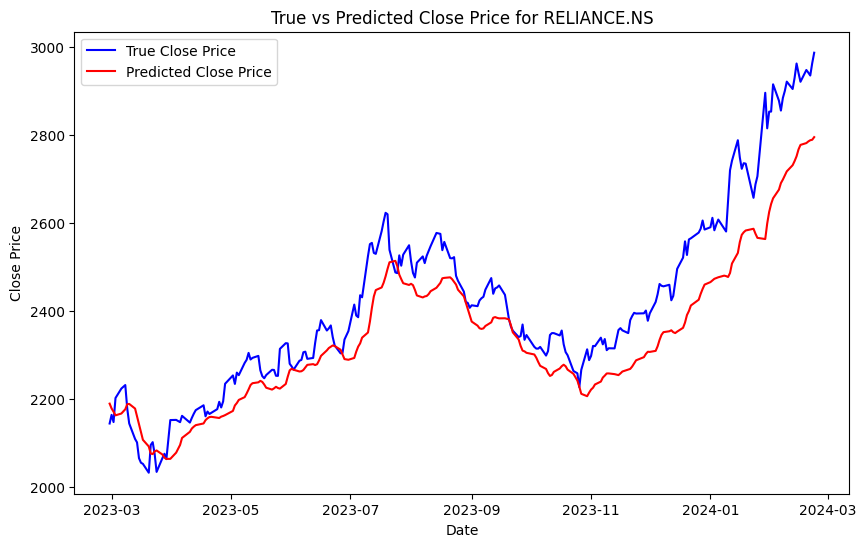

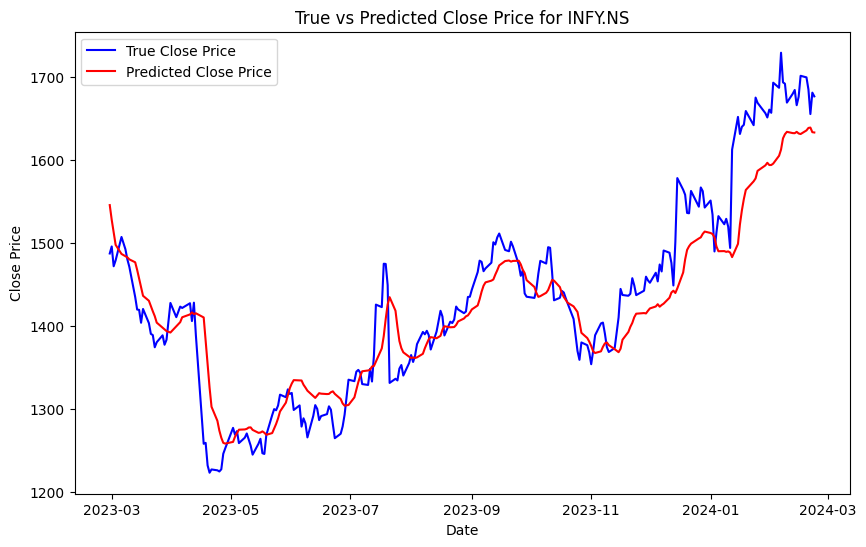

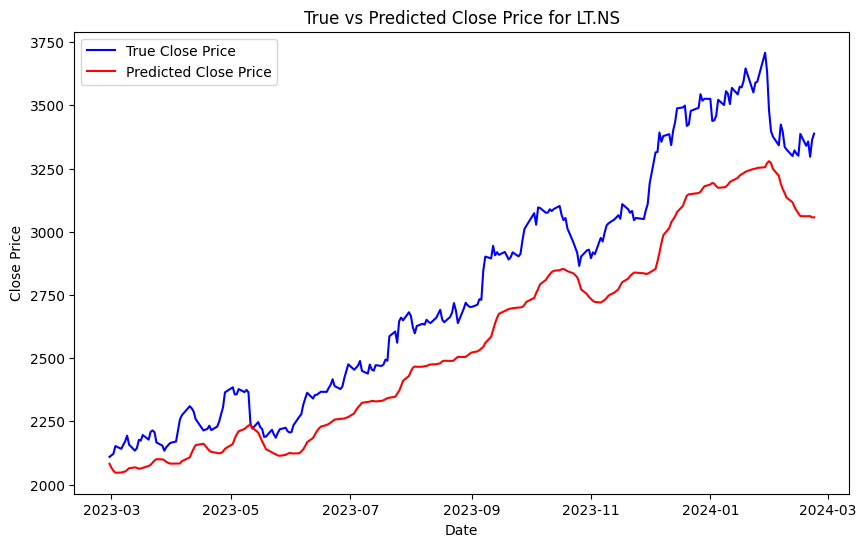

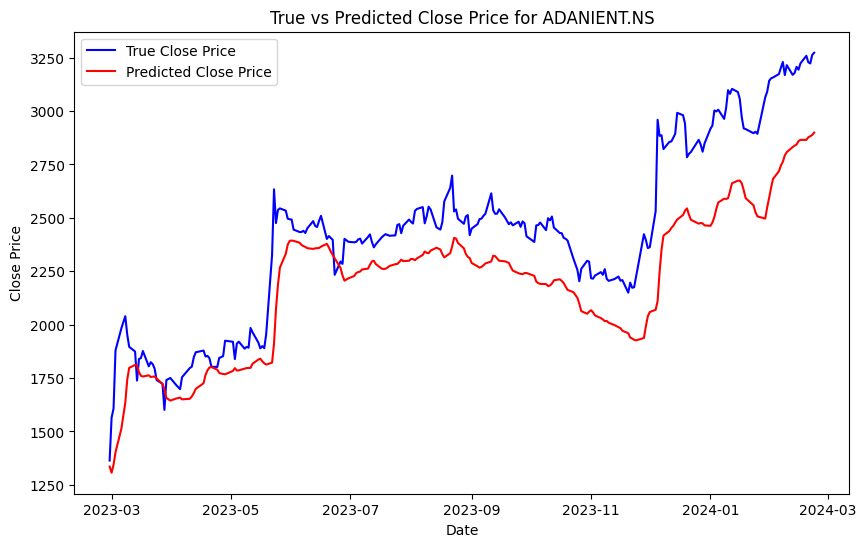

In [3]:
import matplotlib.pyplot as plt

# Function to plot the results
def plot_results(date_list, true_values, predicted_values, ticker):
    plt.figure(figsize=(10, 6))
    plt.plot(date_list, true_values, label='True Close Price', color='blue')
    plt.plot(date_list, predicted_values, label='Predicted Close Price', color='red')
    plt.title(f'True vs Predicted Close Price for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Plot the results for each ticker
for i, ticker in enumerate(tickers):
    date_list = dfs[ticker].index.tolist()[-len(y_test_original_scale):]
    true_values = y_test_original_scale[:, i]
    predicted_values = predictions_original_scale[:, i]
    plot_results(date_list, true_values, predicted_values, ticker)


In [4]:
# Define the number of future time steps to predict
num_future_time_steps = 10  # For example, predict the next 10 days

# Prepare input data for the future period you want to predict
future_start_date = datetime.now() + pd.DateOffset(days=1)
future_end_date = datetime.now() + pd.DateOffset(days=num_future_time_steps)

# Use the latest available historical data for prediction
X_future = X_test[-num_future_time_steps:]

# Use the loaded model to make predictions for the future period
future_predictions = loaded_model.predict(X_future)

# Inverse transform the predictions to get the actual predicted values
future_predictions_original_scale = scaler.inverse_transform(future_predictions)

# Print the predicted future trends
tickers = ['RELIANCE.NS', 'INFY.NS', 'LT.NS', 'ADANIENT.NS']

print("Predicted future trends:")
print(future_predictions_original_scale)

1/1 [==============================] - 0s 36ms/step
Predicted future trends:
[[2731.3801 1632.5989 3116.454  2831.5205]
 [2740.7593 1632.48   3097.9763 2838.2756]
 [2751.6548 1634.1138 3084.242  2843.363 ]
 [2767.2727 1632.1425 3072.4934 2859.4883]
 [2777.5527 1631.4629 3061.738  2865.2993]
 [2781.685  1635.8053 3060.936  2865.1619]
 [2785.383  1638.8258 3061.3042 2877.1704]
 [2788.1614 1639.2595 3061.7495 2882.4263]
 [2789.2122 1633.7015 3056.3474 2888.356 ]
 [2795.239  1633.3547 3056.9707 2899.188 ]]


In [5]:
# Separate the predicted future trends for each stock
predicted_prices_reliance = future_predictions_original_scale[:, 0]
predicted_prices_infy = future_predictions_original_scale[:, 1]

predicted_prices_lt = future_predictions_original_scale[:, 2]
predicted_prices_adanient = future_predictions_original_scale[:, 3]

# Print the predicted prices for each stock over the next 10 days
print("\nPredicted prices for RELIANCE over the next 10 days:")
print(predicted_prices_reliance)

print()
print("Predicted prices for INFY over the next 10 days:")
print(predicted_prices_infy)

print()
print("\nPredicted prices for LT over the next 10 days:")
print(predicted_prices_lt)

print()
print("\nPredicted prices for ADANIENT over the next 10 days:")
print(predicted_prices_adanient)



Predicted prices for RELIANCE over the next 10 days:
[2731.3801 2740.7593 2751.6548 2767.2727 2777.5527 2781.685  2785.383
 2788.1614 2789.2122 2795.239 ]

Predicted prices for INFY over the next 10 days:
[1632.5989 1632.48   1634.1138 1632.1425 1631.4629 1635.8053 1638.8258
 1639.2595 1633.7015 1633.3547]


Predicted prices for LT over the next 10 days:
[3116.454  3097.9763 3084.242  3072.4934 3061.738  3060.936  3061.3042
 3061.7495 3056.3474 3056.9707]


Predicted prices for ADANIENT over the next 10 days:
[2831.5205 2838.2756 2843.363  2859.4883 2865.2993 2865.1619 2877.1704
 2882.4263 2888.356  2899.188 ]


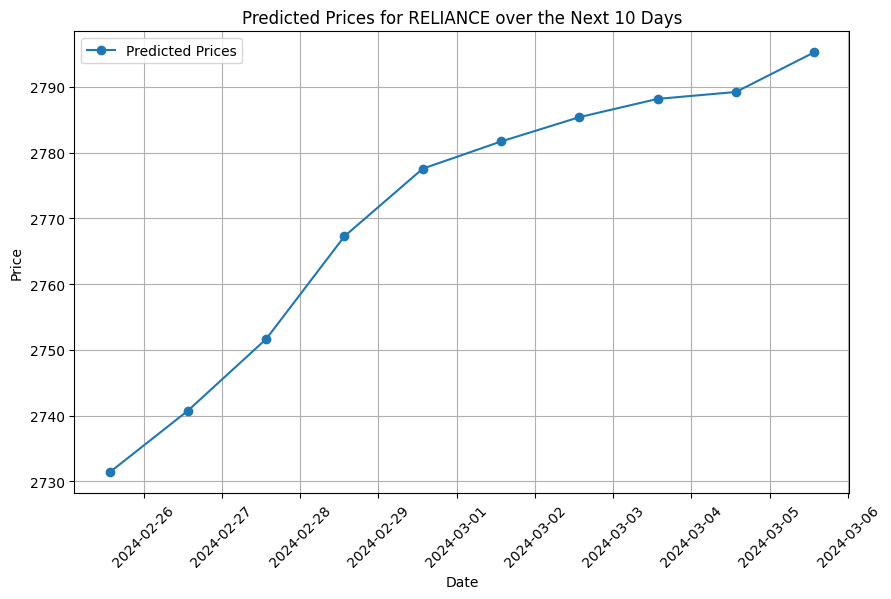

In [7]:
import matplotlib.pyplot as plt

# Get the dates for the next 10 days
future_dates = pd.date_range(start=future_start_date, periods=num_future_time_steps)

# Plotting the predicted prices for RELIANCE
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predicted_prices_reliance, marker='o', label='Predicted Prices')
plt.title('Predicted Prices for RELIANCE over the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()



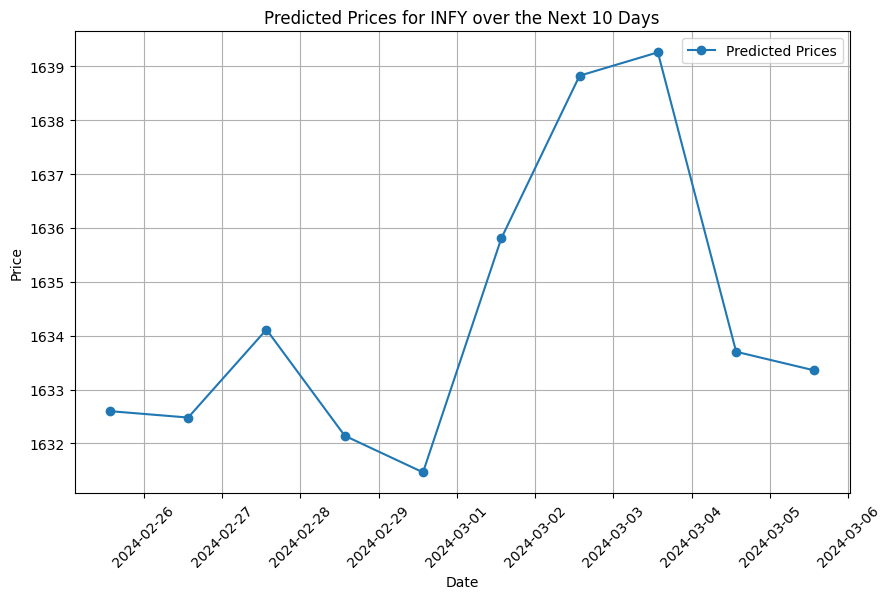

In [8]:
# Plotting the predicted prices for INFY
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predicted_prices_infy, marker='o', label='Predicted Prices')
plt.title('Predicted Prices for INFY over the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

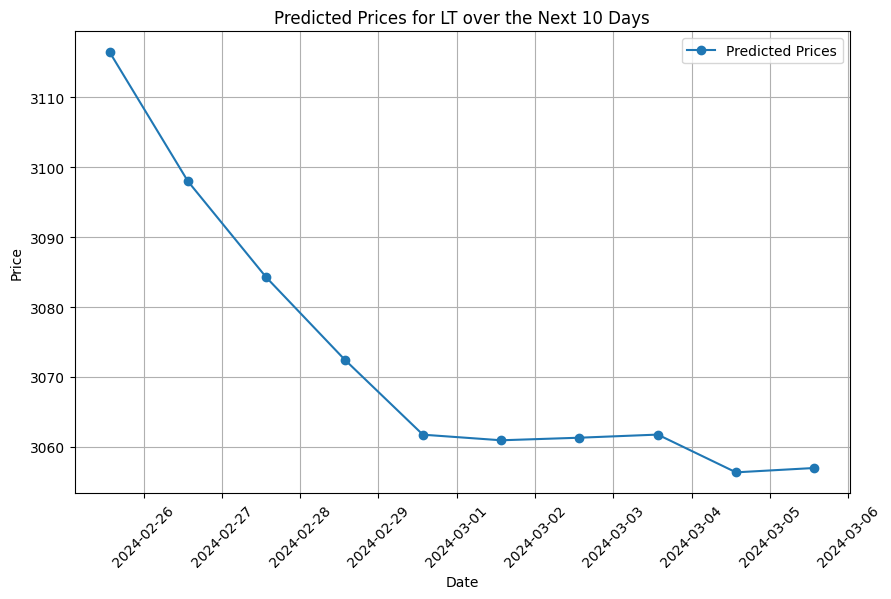

In [9]:

# Plotting the predicted prices for LT
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predicted_prices_lt, marker='o', label='Predicted Prices')
plt.title('Predicted Prices for LT over the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


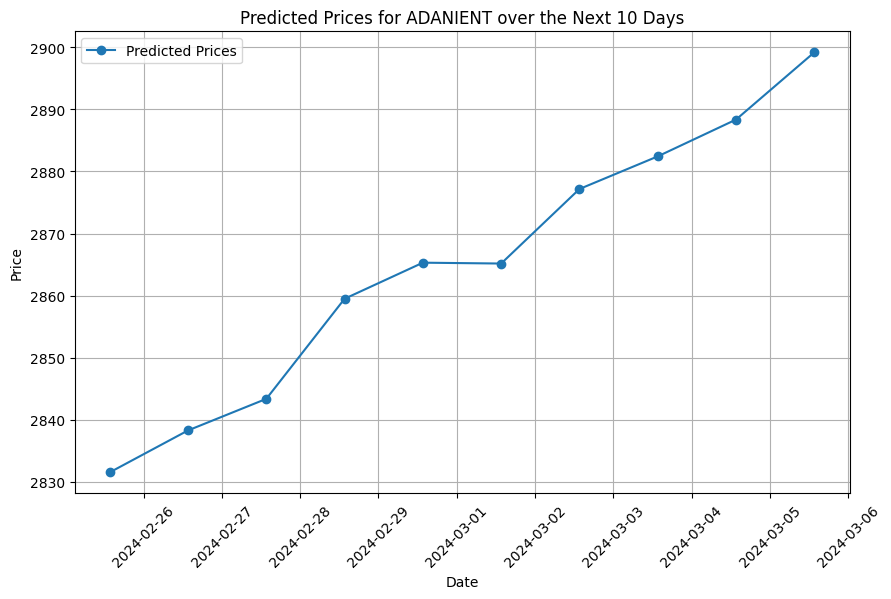

In [10]:

# Plotting the predicted prices for ADANIENT
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predicted_prices_adanient, marker='o', label='Predicted Prices')
plt.title('Predicted Prices for ADANIENT over the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.show()